<a href="https://colab.research.google.com/github/simecek/dspracticum2023/blob/main/lesson03/Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import timm
import os

import matplotlib.pyplot as plt
import PIL
from PIL import Image
import json

import torch
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary
from matplotlib import pyplot as plt
from fastai.vision.all import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


## ConvNeXt


In [3]:
model_name = "convnext_tiny.fb_in22k"
convnext = timm.create_model(model_name, pretrained=True).to(device)

In [4]:
# you can also list all models available or search through wildcard
timm.list_models('*convnext*')

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_mlp',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge',
 'convnext_xxlarge',
 'convnextv2_atto',
 'convnextv2_base',
 'convnextv2_femto',
 'convnextv2_huge',
 'convnextv2_large',
 'convnextv2_nano',
 'convnextv2_pico',
 'convnextv2_small',
 'convnextv2_tiny']

In [5]:
summary(convnext, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 64, 64]           4,704
       LayerNorm2d-2           [-1, 96, 64, 64]             192
          Identity-3           [-1, 96, 64, 64]               0
            Conv2d-4           [-1, 96, 64, 64]           4,800
         LayerNorm-5           [-1, 64, 64, 96]             192
            Linear-6          [-1, 64, 64, 384]          37,248
              GELU-7          [-1, 64, 64, 384]               0
           Dropout-8          [-1, 64, 64, 384]               0
          Identity-9          [-1, 64, 64, 384]               0
           Linear-10           [-1, 64, 64, 96]          36,960
          Dropout-11           [-1, 64, 64, 96]               0
              Mlp-12           [-1, 64, 64, 96]               0
         Identity-13           [-1, 96, 64, 64]               0
         Identity-14           [-1, 96,

### download label mapping for the model

In [6]:
!wget https://dl.fbaipublicfiles.com/convnext/label_to_words.json
imagenet_labels = json.load(open('label_to_words.json'))

--2023-10-08 16:57:52--  https://dl.fbaipublicfiles.com/convnext/label_to_words.json
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.165.140.57, 18.165.140.34, 18.165.140.3, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.165.140.57|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 773945 (756K) [application/json]
Saving to: ‘label_to_words.json.2’

label_to_words.json 100%[===================>] 755.81K  1.08MB/s    in 0.7s    

2023-10-08 16:57:54 (1.08 MB/s) - ‘label_to_words.json.2’ saved [773945/773945]



In [7]:
imagenet_labels

{'0': 'organism, being',
 '1': 'benthos',
 '2': 'heterotroph',
 '3': 'cell',
 '4': 'person, individual, someone, somebody, mortal, soul',
 '5': 'animal, animate being, beast, brute, creature, fauna',
 '6': 'plant, flora, plant life',
 '7': 'food, nutrient',
 '8': 'artifact, artefact',
 '9': 'hop',
 '10': 'check-in',
 '11': 'dressage',
 '12': 'curvet, vaulting',
 '13': 'piaffe',
 '14': 'funambulism, tightrope walking',
 '15': 'rock climbing',
 '16': 'contact sport',
 '17': 'outdoor sport, field sport',
 '18': 'gymnastics, gymnastic exercise',
 '19': 'acrobatics, tumbling',
 '20': 'track and field',
 '21': 'track, running',
 '22': 'jumping',
 '23': 'broad jump, long jump',
 '24': 'high jump',
 '25': 'Fosbury flop',
 '26': 'skiing',
 '27': 'cross-country skiing',
 '28': 'ski jumping',
 '29': 'water sport, aquatics',
 '30': 'swimming, swim',
 '31': 'bathe',
 '32': 'dip, plunge',
 '33': 'dive, diving',
 '34': 'floating, natation',
 '35': "dead-man's float, prone float",
 '36': 'belly flop, 

### download random image and predict it via ConvNeXt

In [8]:
!wget --output-document=test.jpeg https://upload.wikimedia.org/wikipedia/commons/d/d7/Squirrel_in_Seurasaari_autumn.JPG
img = PIL.Image.open('test.jpeg')

# Define transforms for image
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

transformations = [
              transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC), # resize smaller edge to 256
              transforms.ToTensor(),
              transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
              ]

transformations = transforms.Compose(transformations)

img_tensor = transformations(img).unsqueeze(0).to(device)

--2023-10-08 16:57:58--  https://upload.wikimedia.org/wikipedia/commons/d/d7/Squirrel_in_Seurasaari_autumn.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 185.15.59.240, 2a02:ec80:300:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|185.15.59.240|:443... connected.


HTTP request sent, awaiting response... 200 OK
Length: 1338514 (1.3M) [image/jpeg]
Saving to: ‘test.jpeg’

test.jpeg           100%[===================>]   1.28M  6.03MB/s    in 0.2s    

2023-10-08 16:57:59 (6.03 MB/s) - ‘test.jpeg’ saved [1338514/1338514]



In [9]:
img_tensor[0].size()


torch.Size([3, 256, 384])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


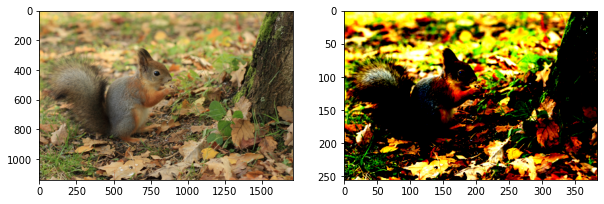

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.imshow(img)
ax2.imshow(img_tensor[0].permute(1, 2, 0))

### predict label for our image

red squirrel, cat squirrel, Sciurus vulgaris 10.49%
fox squirrel, eastern fox squirrel, Sciurus niger 5.56%
American red squirrel, spruce squirrel, red squirrel, Sciurus hudsonicus, Tamiasciurus hudsonicus 4.00%
squirrel 2.53%
chickeree, Douglas squirrel, Tamiasciurus douglasi 2.33%


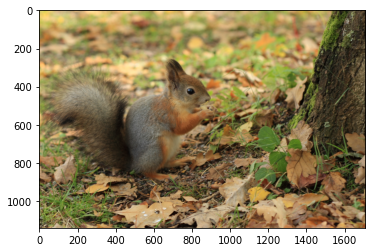

In [11]:
output = torch.softmax(convnext(img_tensor), dim=1)
top5 = torch.topk(output, k=5)
top5_prob = top5.values[0]
top5_indices = top5.indices[0]

for i in range(5):
    labels = imagenet_labels[str(int(top5_indices[i]))]
    prob = "{:.2f}%".format(float(top5_prob[i])*100)
    print(labels, prob)

plt.imshow(img)



---



## Our custom dataset - Tom & Jerry

https://www.kaggle.com/datasets/balabaskar/tom-and-jerry-image-classification

---



In [12]:
DATASET = 'balabaskar/tom-and-jerry-image-classification'
ZIP_PATH = './tom-and-jerry-image-classification.zip'
IMAGES_PATH = './tom_and_jerry/tom_and_jerry'

In [13]:
os.environ['KAGGLE_USERNAME'] = 'evaklimentov'
os.environ['KAGGLE_KEY'] = 'c3161c890c8b21e1e5cba18c9a7505c0'

!kaggle datasets download -d {DATASET} -p ./

tom-and-jerry-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [14]:
import zipfile

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall('./')

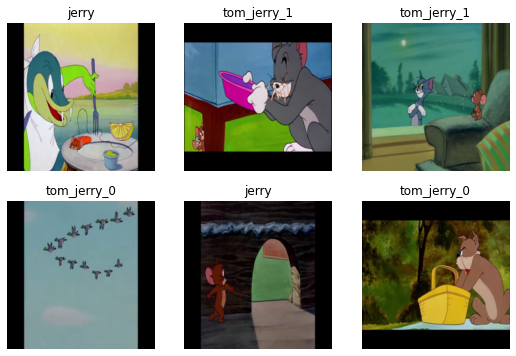

In [15]:
images = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(256, method='squish'))

dls = images.dataloaders(IMAGES_PATH, bs=64)

dls.show_batch(max_n=6)

In [16]:
print(len(dls.train.dataset))
print(len(dls.valid.dataset))

4383
1095


## Load ConvNeXt model and fine-tune it

In [17]:
learn = vision_learner(dls, convnext_tiny, metrics=accuracy)
learn.fine_tune(3, freeze_epochs=1)

/var/essdata/IDU/venvs/common_venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/var/essdata/IDU/venvs/common_venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time


epoch,train_loss,valid_loss,accuracy,time
0,0.692367,0.444616,0.831963,05:02
1,0.491525,0.312866,0.888584,04:53
2,0.334910,0.295715,0.894064,04:55


## See how our model performs:


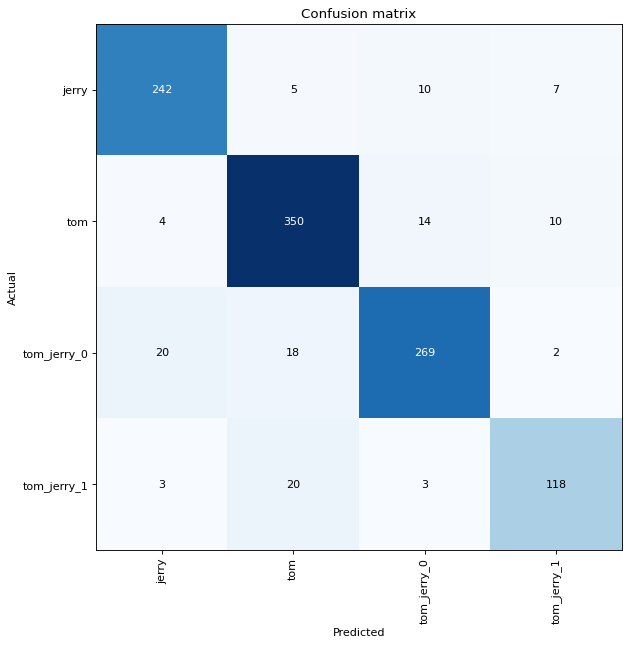

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=80)

### what is hard to predic?

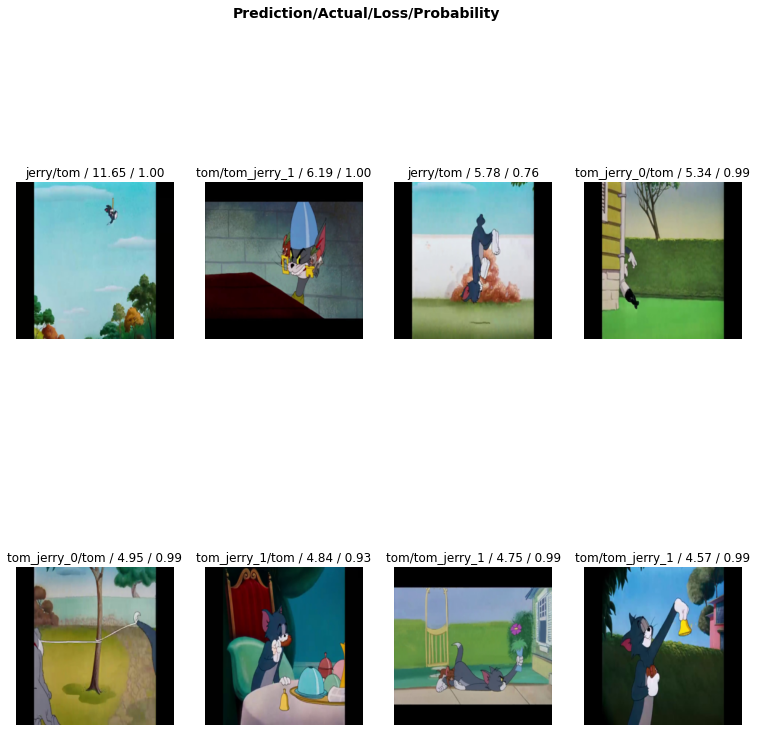

In [19]:
interp.plot_top_losses(8, figsize=(13,13))

## Predict a new image

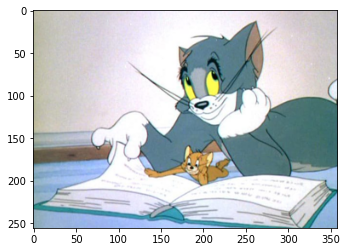

In [27]:
img = PIL.Image.open('tom-jer.jpg')

res = transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC)
img = res(img)
plt.imshow(img)

In [39]:
pred,pred_idx,probs = learn.predict(img)
print("Prediction:", pred)
for p, cl in zip(probs, dls.vocab):
    print("Probability for class", cl, "-", p)

Prediction: tom
Probability for class jerry - tensor(0.0012)
Probability for class tom - tensor(0.6870)
Probability for class tom_jerry_0 - tensor(0.0001)
Probability for class tom_jerry_1 - tensor(0.3117)


## Data augmentation

use image transformations from https://docs.fast.ai/vision.augment.html

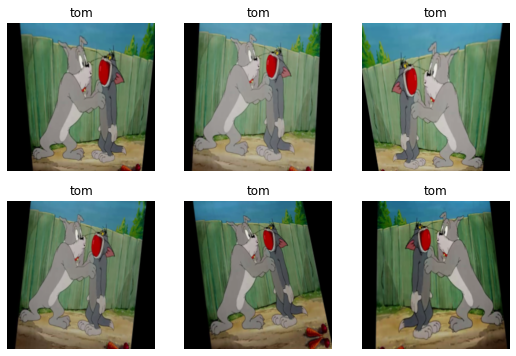

In [48]:
tfms = aug_transforms() # TODO

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(256, method='squish')],
    batch_tfms=tfms
).dataloaders(IMAGES_PATH, bs=64)

dls.show_batch(max_n=6, unique=True)

In [49]:
print(len(dls.train.dataset))
print(len(dls.valid.dataset))

4383
1095


In [50]:
learn = vision_learner(dls, convnext_tiny, metrics=accuracy)
learn.fine_tune(3, freeze_epochs=1)

/var/essdata/IDU/venvs/common_venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/var/essdata/IDU/venvs/common_venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,1.449247,0.769138,0.731507,03:42


epoch,train_loss,valid_loss,accuracy,time
0,0.796949,0.524247,0.811872,05:27
1,0.601861,0.349848,0.868493,05:27
2,0.452761,0.325312,0.875799,05:17


### Diving into `fine_tune`

Let's uncover what's inside:

`fine_tune` = `learn.freeze(), learn.fit_one_cycle(), learn.unfreeze(), learn.fit_one_cycle()`

but at first, let's have a look at what happens with the learning rate during the training we performed

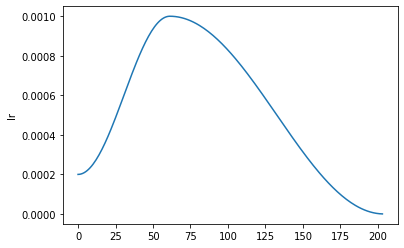

In [51]:
learn.recorder.plot_sched(keys='lr')

In [52]:
learn = vision_learner(dls, convnext_tiny, metrics=accuracy)
learn.freeze()
learn.summary()

Sequential (Input shape: 64 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 96 x 64 x 64   
Conv2d                                    4704       False     
LayerNorm2d                               192        True      
Conv2d                                    4800       False     
____________________________________________________________________________
                     64 x 64 x 64 x 96   
Permute                                                        
LayerNorm                                 192        True      
____________________________________________________________________________
                     64 x 64 x 64 x 384  
Linear                                    37248      False     
GELU                                                           
____________________________________________________________________________
                     64 x 64 x 64 x 96   
Linear                                    36

In [53]:
learn.fit(1, 0.5)

epoch,train_loss,valid_loss,accuracy,time
0,30.930775,7.457420,0.241096,03:38


In [54]:
learn.unfreeze()
learn.fit(3, 0.5)

epoch,train_loss,valid_loss,accuracy,time
0,27.868088,6.395280,0.282192,05:26
1,10.615371,5.549100,0.282192,05:34
2,18.935854,24.047701,0.345205,05:34
